# Tenencia del producto préstamo en el DataSet de Banco Checo  

Vamos a intentar extraer del datset generado que variables son las más relevantes para que una cuenta (account) tenga un péstamo (loan) y ver si de esta forma podemos generar un customer journey para conseguir que un cliente contrate un préstamo

In [1]:
import pandas as pd
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Cargamos los datos que hemos procesado en R
df_original= pd.read_csv("C://Master Data Science/Master en Data Science/TFM/Transacciones de Banco Checo/DFTenenciaProductos2.csv")

In [3]:
#Comenzamos a revisar que el DF se haya importado correctamente
df_original.shape

(4500, 70)

In [4]:
df_original.head()

,Unnamed: 0,district_id,account_id,frequency,Date_Account,client_id_owner,client_id_disponent,sex_owner,birth_owner,sex_disponent,...,Num_Sym_Pension,Num_Sym_Insurance,Num_Sym_NegBal,Num_Sym_Household,Num_Sym_Statement,Num_Sym_IntDep,Num_Sym_LoanPayment,Balance_in_negative,account_disponent_bin,account_loan_bin
0,1,1,1938,Monthly,1994-06-25,2354,NaN,M,1967-12-21,NaN,...,0,0,0,50,49,54,0,0,0,0
1,2,1,1562,Monthly,1995-08-30,1894,NaN,F,1947-11-05,NaN,...,0,0,0,36,35,36,0,0,0,0
2,3,1,7099,Monthly,1996-08-20,8568,NaN,F,1971-12-03,NaN,...,0,24,0,24,23,28,7,0,0,1
3,4,1,2316,Monthly,1997-07-21,2802,NaN,F,1966-11-29,NaN,...,0,0,0,13,12,17,0,0,0,0
4,5,1,1570,Monthly,1994-03-12,1903,NaN,F,1939-08-30,NaN,...,57,0,0,53,52,53,0,0,0,0


In [5]:
# Vamos a analizar si hay missings al cargar los datos a Python
df_original.columns[df_original.isnull().sum()!=0]
#Vemos que las variables con missings provienen de variables que ya tenían esos missings en el DataFrame generado con R,
#ya que el disponent (autorizado), los préstamos y las tarjetas no son productos que tengan asociados todas las cuentas  

Index(['client_id_disponent', 'sex_disponent', 'birth_disponent', 'loan_id',
       'Date_Loan', 'Amount_Loan', 'Duration_Loan', 'Payments_Loan', 'status',
       'Status_Loan', 'owner_card_date'],
      dtype='object')

In [6]:
#Vemos como se han importado las variables del DataFrame de R al DataFrame que vamos a utilizar en Python 
print(df_original.iloc[:,0:32].dtypes)
print(df_original.iloc[:,31:61].dtypes)
print(df_original.iloc[:,60:70].dtypes)
#Observamos que las variables de factor y de fecha han modificado su tipo de variable, 
#por lo que tendremos que trabajar con ellas

Unnamed: 0                        int64
district_id                       int64
account_id                        int64
frequency                        object
Date_Account                     object
client_id_owner                   int64
client_id_disponent             float64
sex_owner                        object
birth_owner                      object
sex_disponent                    object
birth_disponent                  object
loan_id                         float64
Date_Loan                        object
Amount_Loan                     float64
Duration_Loan                   float64
Payments_Loan                   float64
status                           object
Status_Loan                      object
Ord_Insurance                     int64
Ord_Insurance_amount              int64
Ord_Household_Payment             int64
Ord_Household_Payment_amount      int64
Ord_Loan_Payment                  int64
Ord_Loan_Payment_amount         float64
Ord_Leasing                       int64


In [7]:
#Transformamos a formato fecha las variables que originalmente eran fecha en R
df_original[["Date_Account","birth_owner", "birth_disponent", "Date_Loan", "owner_card_date"]]=df_original[["Date_Account","birth_owner", "birth_disponent", "Date_Loan", "owner_card_date"]].apply(pd.to_datetime)
from datetime import datetime
df_original['Date_Account']=df_original['Date_Account'].apply(datetime.toordinal)
df_original['birth_owner']=df_original['birth_owner'].apply(datetime.toordinal)
df_original['birth_disponent']=df_original['birth_disponent'].apply(datetime.toordinal)
df_original['Date_Loan']=df_original['Date_Loan'].apply(datetime.toordinal)
df_original['owner_card_date']=df_original['owner_card_date'].apply(datetime.toordinal)

In [8]:
#De todas las variables de las que disponemos, vamos a seleccionar las que vamos a utilizar en este ejercicio:

#La  variable que vamos a predecir va a ser "account_loan_bin" y por tanto la denominaremos "y"

#Para este ejercicio no consideramos las variables que hemos obtenido en el mismo fichero que la variable a predecir (loan.csv):
#loan_id, Date_Loan, Amount_Loan, Duration_Loan, Payments_Loan, status, Status_Loan.

#Otras variables que no consideramos: account_id, client_id_owner, client_id_disponent, district ID y unnamed:0 porque 
#son ID's descriptivas sin información para utilizar

#La variable disponent_card_type no aporta información

#Otras variables que no consideramos:district_name, region (nombre). Utilizamos el resto de la información de variables 
#del fichero district.csv

#Haciendo referencia a district.csv , la información de crimes_95, crimes_96 y entrepreneurs la vamos a utilizar como ratio,
#ya que como veremos a continuación, de esta forma obtendremos menos impacto por un distrito con mucha población (Praga) 



In [9]:
#Las variables crimes_95, crimes_96 y entrepreneurs vamos a utilizarlas en formato ratio, tal y como calculamos en R

(array([3443.,  240.,  263.,    0.,    0.,    0.,    0.,    0.,    0.,
         554.]),
 array([  818. ,  9303.9, 17789.8, 26275.7, 34761.6, 43247.5, 51733.4,
        60219.3, 68705.2, 77191.1, 85677. ]),
 <a list of 10 Patch objects>)

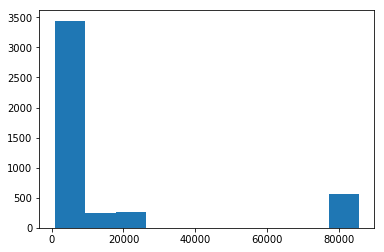

In [10]:
plt.hist(df_original['crimes_95'])

(array([ 596., 1052.,  499.,  760.,  370.,  317.,  128.,  224.,    0.,
         554.]),
 array([0.01354271, 0.01929884, 0.02505497, 0.0308111 , 0.03656723,
        0.04232336, 0.04807949, 0.05383562, 0.05959176, 0.06534789,
        0.07110402]),
 <a list of 10 Patch objects>)

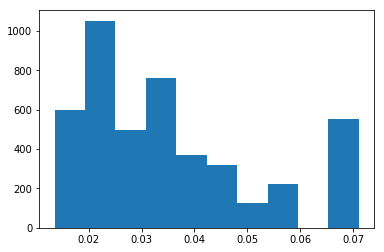

In [11]:
plt.hist(df_original['crimes_95_ratio'])

(array([3683.,  263.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         554.]),
 array([  888. , 10709.9, 20531.8, 30353.7, 40175.6, 49997.5, 59819.4,
        69641.3, 79463.2, 89285.1, 99107. ]),
 <a list of 10 Patch objects>)

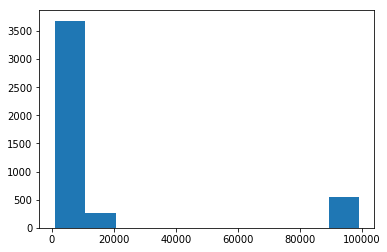

In [12]:
plt.hist(df_original['crimes_96'])

(array([1141.,  804.,  726.,  637.,  415.,   88.,  135.,    0.,    0.,
         554.]),
 array([0.0159461 , 0.02257646, 0.02920682, 0.03583717, 0.04246753,
        0.04909789, 0.05572825, 0.06235861, 0.06898896, 0.07561932,
        0.08224968]),
 <a list of 10 Patch objects>)

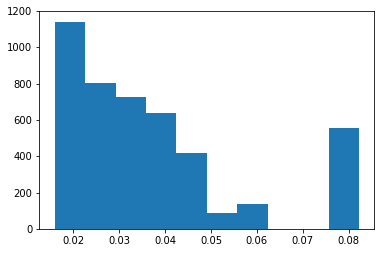

In [13]:
plt.hist(df_original['crimes_96_ratio'])

(array([200., 354., 644., 992., 517., 757., 259., 138.,  85., 554.]),
 array([ 81. ,  89.6,  98.2, 106.8, 115.4, 124. , 132.6, 141.2, 149.8,
        158.4, 167. ]),
 <a list of 10 Patch objects>)

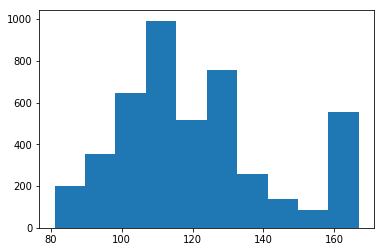

In [14]:
plt.hist(df_original['entrepreneurs'])

(array([ 969.,  322., 1256.,  793.,  312.,  388.,  177.,  192.,   43.,
          48.]),
 array([0.00013859, 0.00041431, 0.00069003, 0.00096575, 0.00124147,
        0.00151719, 0.0017929 , 0.00206862, 0.00234434, 0.00262006,
        0.00289578]),
 <a list of 10 Patch objects>)

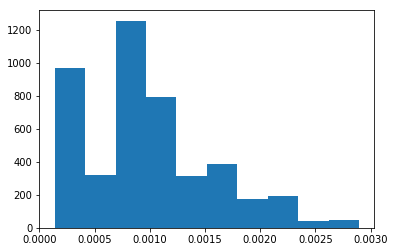

In [15]:
plt.hist(df_original['entrepreneurs_ratio'])

In [16]:
#Creamos un DataFrame con las variables que vamos a considerar numéricas
df_num=df_original[['Date_Account','birth_owner', 'birth_disponent','owner_card_date','Ord_Insurance', 'Ord_Insurance_amount',
                    'Ord_Household_Payment','Ord_Household_Payment_amount', 'Ord_Loan_Payment', 'Ord_Leasing',
                    'Ord_Empty', 'Ord_Empty_amount', 'num_inhabitants', 'municip < 499', 'municip 500-1999',
                    'municip 2000-9999', 'municip > 10000', 'num_cities', 'avg_salary',  
                    'Num_Type_Credit', 'Num_Type_VYBER', 'Num_Type_Withdrawal', 'Num_Op_Null', 'Num_Op_Remittances',
                    'Num_Op_Collection','Num_Op_CashCredit', 'Num_Op_WithdrawalCash','Num_Op_WithdrawalCreditCard',
                    'Num_Sym_Null', 'Num_Sym_Null2','Num_Sym_Pension', 'Num_Sym_Insurance', 'Num_Sym_NegBal',
                    'Num_Sym_Household', 'Num_Sym_Statement', 'Num_Sym_IntDep', 'Num_Sym_LoanPayment', 
                    'Balance_in_negative','Ord_Loan_Payment_amount', 'Ord_Leasing_amount','ratio_urban_inhabitants',
                    'unemployment_rate_95','unemployment_rate_96', 'crimes_95_ratio', 'crimes_96_ratio', 'entrepreneurs_ratio' ]] 

In [17]:
#Creamos un DataFrame con las variables que vamos a considerar categóricas
df_cat=df_original[['account_disponent_bin','frequency', 'sex_owner', 'owner_card_type',
       'sex_disponent']]
#Vemos que tipos tienen las variables que queremos que sean categóricas
df_cat.dtypes

account_disponent_bin     int64
frequency                object
sex_owner                object
owner_card_type           int64
sex_disponent            object
dtype: object

In [18]:
#Ponemos las variables "owner_card_type" y "account_disponent_bin" como string para poder obtener dummies
df_cat["owner_card_type"]=df_cat["owner_card_type"].astype(str)
df_cat["account_disponent_bin"]=df_cat["account_disponent_bin"].astype(str)

C:\Users\osmaa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\osmaa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
df_cat_dumm=pd.get_dummies(df_cat)

In [20]:
df_cat_dumm.dtypes
#Al pasar a dummies las variables, hemos incrementado en 8 el número total de variables

account_disponent_bin_0    uint8
account_disponent_bin_1    uint8
frequency_After_trans      uint8
frequency_Monthly          uint8
frequency_Weekly           uint8
sex_owner_F                uint8
sex_owner_M                uint8
owner_card_type_0          uint8
owner_card_type_1          uint8
owner_card_type_2          uint8
owner_card_type_3          uint8
sex_disponent_F            uint8
sex_disponent_M            uint8
dtype: object

In [21]:
df = pd.concat([df_num, df_cat_dumm], axis = 1)
df.head()

,Date_Account,birth_owner,birth_disponent,owner_card_date,Ord_Insurance,Ord_Insurance_amount,Ord_Household_Payment,Ord_Household_Payment_amount,Ord_Loan_Payment,Ord_Leasing,...,frequency_Monthly,frequency_Weekly,sex_owner_F,sex_owner_M,owner_card_type_0,owner_card_type_1,owner_card_type_2,owner_card_type_3,sex_disponent_F,sex_disponent_M
0,728104,718421,1,1,0,0,1,6646,0,1,...,1,0,0,1,1,0,0,0,0,0
1,728535,711070,1,1,0,0,1,1933,0,0,...,1,0,1,0,1,0,0,0,0,0
2,728891,719864,1,1,1,528,1,236,1,0,...,1,0,1,0,1,0,0,0,0,0
3,729226,718034,1,1,0,0,1,2111,0,0,...,1,0,1,0,1,0,0,0,0,0
4,727999,708081,1,1,0,0,1,2865,0,0,...,1,0,1,0,1,0,0,0,0,0


# Vamos a generar un primer modelo benchmark

In [22]:
#Antes de probar con modelos vamos a ver si reduciendo dimensionalidad conseguimos una primera intuición

In [23]:
X = df
y = df_original["account_loan_bin"] 

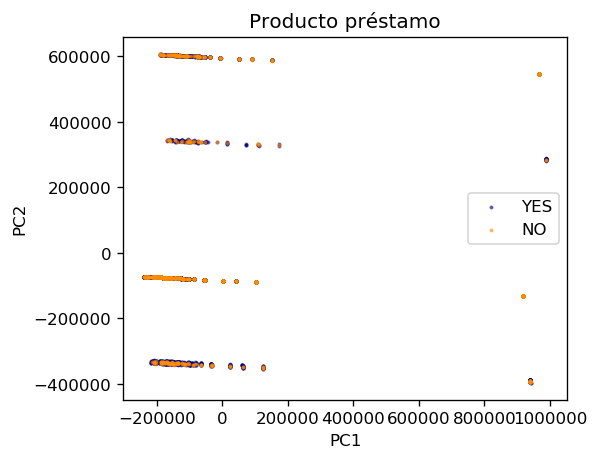

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit_transform(X)
plt.figure(dpi=120)
plt.scatter(pca[y.values==0,0], pca[y.values==0,1], alpha=0.5, label='YES', s=2, color='navy')
plt.scatter(pca[y.values==1,0], pca[y.values==1,1], alpha=0.5, label='NO', s=2, color='darkorange')
plt.legend()
plt.title('Producto préstamo')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.gca().set_aspect('equal')
plt.show()

In [25]:
#Del gráfico anterior no consigo sacar nada en claro
pca2 = PCA(n_components=2)
pca2.fit(X)
print(pca2.components_)
print(pca2.explained_variance_ratio_)
#De los componentes una intuición de que quizás las variables 3 ('birth_disponent'),4 ('owner_card_date') y 
#13 'num_inhabitants' podrían ser importantes

[[-1.41899145e-05  3.76112969e-04  2.97418890e-02  6.65291847e-02
   1.10456611e-08  6.97541426e-05 -8.13236480e-09  4.49340526e-05
   1.92086580e-09  1.51642509e-08  1.86478704e-08  1.40767450e-04
   9.97335487e-01 -4.90984072e-05 -2.32177716e-05 -5.72845134e-06
  -5.87189940e-07 -5.04538511e-06  3.32207470e-03  2.80449536e-06
   4.49809421e-07  3.59443953e-06  1.27687280e-06  5.86459693e-07
  -1.80003778e-06  3.32766034e-06  2.90427567e-06  5.53513591e-07
   3.95002345e-06  7.30692726e-07 -9.05250243e-07  3.92910956e-07
   9.53161761e-08  5.39244984e-07  4.59238406e-07  1.27687280e-06
   3.09695048e-07  3.58832264e-07  4.66633456e-05  4.45604444e-05
   3.74408574e-05 -2.48007137e-06 -2.94393181e-06  3.92241114e-08
   4.83722236e-08 -1.07124667e-09 -4.19281050e-08  4.19281050e-08
  -4.73145522e-09 -5.56504707e-09  1.02965023e-08  3.63305616e-09
  -3.63305616e-09 -9.12049432e-08  6.41757903e-08  4.74961153e-09
   2.22795413e-08  2.15292322e-08  2.03988728e-08]
 [ 3.04437369e-06  3.7370

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

In [27]:
#Generamos conjuntos de train y de test. PAra el test usamos el 20% de las observaciones
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [28]:
#Probamos una Regresión logística
clf_LR=LogisticRegression()
clf_LR.fit(X_train,y_train)

C:\Users\osmaa\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [36]:
#Predicción en el conjunto de train con Regresión Logística
print("El accuracy es",accuracy_score(y_train,clf_LR.predict(X_train))*100,"%")
print("La precision es",precision_score(y_train,clf_LR.predict(X_train))*100, "%")
print("El recall es",recall_score(y_train,clf_LR.predict(X_train))*100,"%")
tn, fp, fn, tp=confusion_matrix(y_train,clf_LR.predict(X_train)).ravel()
(tn, fp, fn, tp)

El accuracy es 97.25 %
La precision es 95.64315352697096 %
El recall es 85.52875695732838 %


(3040, 21, 78, 461)

In [34]:
#Predicción en el conjunto de test con Regresión Logística
print("El accuracy es",accuracy_score(y_test,clf_LR.predict(X_test))*100,"%")
print("La precision es",precision_score(y_test,clf_LR.predict(X_test))*100, "%")
print("El recall es",recall_score(y_test,clf_LR.predict(X_test))*100,"%")
tn, fp, fn, tp=confusion_matrix(y_test,clf_LR.predict(X_test)).ravel()
(tn, fp, fn, tp)
#Los resultados indican que se puede predecir muy bien con un modelo sencillo y que el modelo generaliza bastante bien 
#(poca diferencia entre train y test).

El accuracy es 96.66666666666667 %
La precision es 94.48818897637796 %
El recall es 83.91608391608392 %


(750, 7, 23, 120)

In [99]:
#Probamos con un árbol de decisión
clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=3)
clf_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [100]:
#Predicción en el conjunto de train con un árbol de prueba
print("El accuracy es",accuracy_score(y_train,clf_tree.predict(X_train))*100,"%")
print("La precision es",precision_score(y_train,clf_tree.predict(X_train))*100, "%")
print("El recall es",recall_score(y_train,clf_tree.predict(X_train))*100,"%")
print("Matriz de confusión",confusion_matrix(y_train,clf_tree.predict(X_train)))
tn, fp, fn, tp=confusion_matrix(y_train,clf_tree.predict(X_train)).ravel()
(tn, fp, fn, tp)

El accuracy es 100.0 %
La precision es 100.0 %
El recall es 100.0 %
Matriz de confusión [[3061    0]
 [   0  539]]


(3061, 0, 0, 539)

In [101]:
#Predicción en el conjunto de test con un árbol de prueba
print("El accuracy es",accuracy_score(y_test,clf_tree.predict(X_test))*100,"%")
print("La precision es",precision_score(y_test,clf_tree.predict(X_test))*100, "%")
print("El recall es",recall_score(y_test,clf_tree.predict(X_test))*100,"%")
print("Matriz de confusión",confusion_matrix(y_test,clf_tree.predict(X_test)))
tn, fp, fn, tp=confusion_matrix(y_test,clf_tree.predict(X_test)).ravel()
(tn, fp, fn, tp)

El accuracy es 100.0 %
La precision es 100.0 %
El recall es 100.0 %
Matriz de confusión [[757   0]
 [  0 143]]


(757, 0, 0, 143)

In [102]:
X_train.columns[clf_tree.feature_importances_>0.001]

Index(['Num_Sym_LoanPayment'], dtype='object')

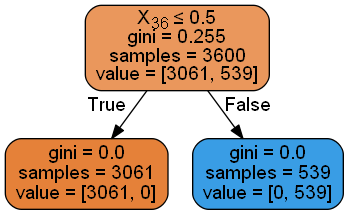

In [103]:
#Vamos a dibujar el modelo
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf_tree, out_file=dot_data,filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [104]:
X_train.columns[36]
#Parece que la variable 'Num_Sym_LoanPayment' contiene toda la información "account_loan_bin", 
#aunque se han extraido de ficheros distintos

'Num_Sym_LoanPayment'

In [105]:
#Vemos que tener un préstamo corrleciona de forma muy significativa con las variables:Ord_Loan_Payment,Num_Sym_LoanPayment y 
#Ord_Loan_Payment_amount
df_original.corr()["account_loan_bin"]

Unnamed: 0                      0.003331
district_id                     0.003010
account_id                      0.555004
Date_Account                    0.015261
client_id_owner                 0.556641
client_id_disponent             0.666977
birth_owner                     0.104253
birth_disponent                 0.021728
loan_id                              NaN
Date_Loan                       1.000000
Amount_Loan                          NaN
Duration_Loan                        NaN
Payments_Loan                        NaN
Ord_Insurance                   0.064054
Ord_Insurance_amount            0.066203
Ord_Household_Payment          -0.115103
Ord_Household_Payment_amount    0.065080
Ord_Loan_Payment                0.970807
Ord_Loan_Payment_amount         0.831433
Ord_Leasing                    -0.121020
Ord_Leasing_amount             -0.105988
Ord_Empty                       0.076714
Ord_Empty_amount                0.098316
owner_card_type                 0.033378
disponent_card_t

In [106]:
X1=X.drop(['Num_Sym_LoanPayment'], axis=1)


In [107]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.2, random_state=0)

In [108]:
clf_tree.fit(X1_train,y1_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [109]:
#Predicción en el conjunto de train con un árbol de prueba
print("El accuracy es",accuracy_score(y1_train,clf_tree.predict(X1_train))*100,"%")
print("La precision es",precision_score(y1_train,clf_tree.predict(X1_train))*100, "%")
print("El recall es",recall_score(y1_train,clf_tree.predict(X1_train))*100,"%")
print("Matriz de confusión",confusion_matrix(y1_train,clf_tree.predict(X1_train)))

El accuracy es 99.55555555555556 %
La precision es 97.9816513761468 %
El recall es 99.07235621521335 %
Matriz de confusión [[3050   11]
 [   5  534]]


In [110]:
#Predicción en el conjunto de test con un árbol de prueba
print("El accuracy es",accuracy_score(y1_test,clf_tree.predict(X1_test))*100,"%")
print("La precision es",precision_score(y1_test,clf_tree.predict(X1_test))*100, "%")
print("El recall es",recall_score(y1_test,clf_tree.predict(X1_test))*100,"%")
print("Matriz de confusión",confusion_matrix(y1_test,clf_tree.predict(X1_test)))

El accuracy es 99.22222222222223 %
La precision es 97.22222222222221 %
El recall es 97.9020979020979 %
Matriz de confusión [[753   4]
 [  3 140]]


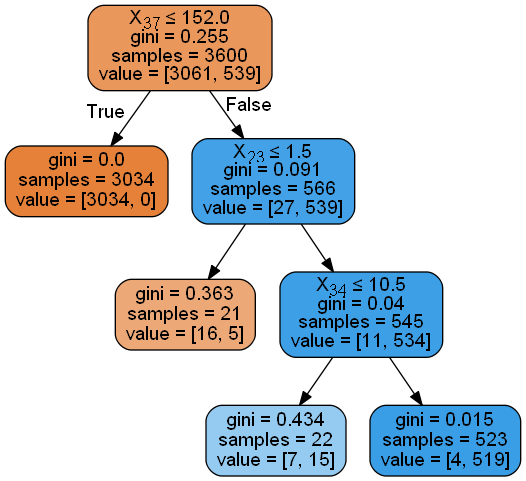

In [111]:
#Vamos a dibujar el modelo
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf_tree, out_file=dot_data,filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [112]:
X1_train.columns[8]

'Ord_Loan_Payment'

In [113]:
#El modelo continua dando unos resultados espectaculares, vamos a ver que sucede si eliminamos la variable 'Ord_Loan_Payment'

In [114]:
X2=X1.drop(['Ord_Loan_Payment'], axis=1)
X2.shape

(4500, 57)

In [115]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, random_state=0)

In [116]:
clf_tree.fit(X2_train,y2_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [117]:
#Predicción en el conjunto de train con un árbol de prueba
print("El accuracy es",accuracy_score(y2_train,clf_tree.predict(X2_train))*100,"%")
print("La precision es",precision_score(y2_train,clf_tree.predict(X2_train))*100, "%")
print("El recall es",recall_score(y2_train,clf_tree.predict(X2_train))*100,"%")
print("Matriz de confusión",confusion_matrix(y2_train,clf_tree.predict(X2_train)))

El accuracy es 99.55555555555556 %
La precision es 97.9816513761468 %
El recall es 99.07235621521335 %
Matriz de confusión [[3050   11]
 [   5  534]]


In [118]:
#Predicción en el conjunto de test con un árbol de prueba
print("El accuracy es",accuracy_score(y2_test,clf_tree.predict(X2_test))*100,"%")
print("La precision es",precision_score(y2_test,clf_tree.predict(X2_test))*100, "%")
print("El recall es",recall_score(y2_test,clf_tree.predict(X2_test))*100,"%")
print("Matriz de confusión",confusion_matrix(y2_test,clf_tree.predict(X2_test)))

El accuracy es 99.22222222222223 %
La precision es 97.22222222222221 %
El recall es 97.9020979020979 %
Matriz de confusión [[753   4]
 [  3 140]]


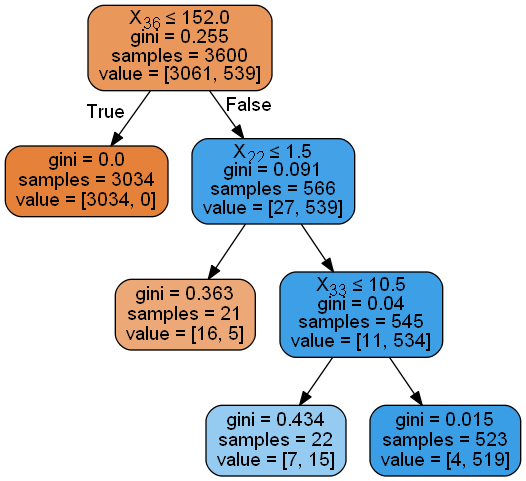

In [119]:
#Vamos a dibujar el modelo
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf_tree, out_file=dot_data,filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [120]:
X2_train.columns[36]

'Ord_Loan_Payment_amount'

In [121]:
#El modelo continua dando unos resultados espectaculares, vamos a ver que sucede si eliminamos la variable 'Ord_Loan_Payment_amount'
X3=X2.drop(['Ord_Loan_Payment_amount'], axis=1)
X3.shape

(4500, 56)

In [122]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.2, random_state=0)

In [123]:
clf_tree.fit(X3_train,y3_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [124]:
#Predicción en el conjunto de train con un árbol de prueba
print("El accuracy es",accuracy_score(y3_train,clf_tree.predict(X3_train))*100,"%")
print("La precision es",precision_score(y3_train,clf_tree.predict(X3_train))*100, "%")
print("El recall es",recall_score(y3_train,clf_tree.predict(X3_train))*100,"%")
print("Matriz de confusión",confusion_matrix(y3_train,clf_tree.predict(X3_train)))

El accuracy es 90.94444444444446 %
La precision es 69.25858951175407 %
El recall es 71.05751391465677 %
Matriz de confusión [[2891  170]
 [ 156  383]]


In [125]:
#Predicción en el conjunto de test con un árbol de prueba
print("El accuracy es",accuracy_score(y3_test,clf_tree.predict(X3_test))*100,"%")
print("La precision es",precision_score(y3_test,clf_tree.predict(X3_test))*100, "%")
print("El recall es",recall_score(y3_test,clf_tree.predict(X3_test))*100,"%")

El accuracy es 89.11111111111111 %
La precision es 65.73426573426573 %
El recall es 65.73426573426573 %


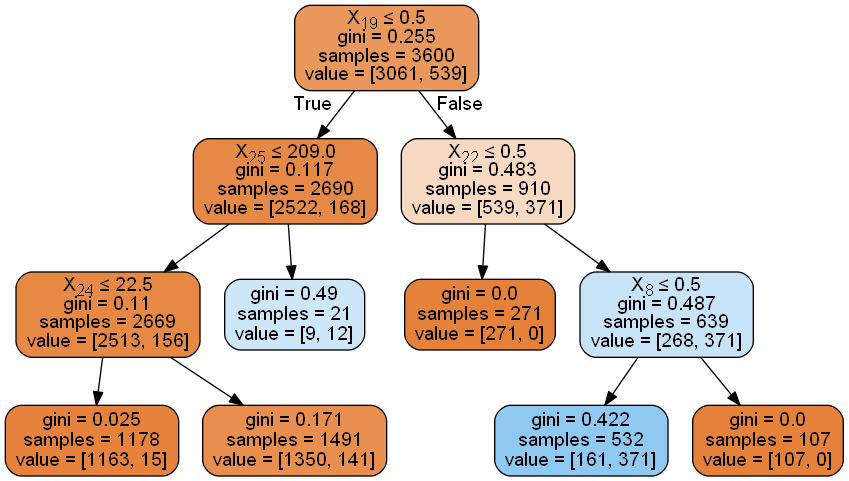

In [126]:
#Vamos a dibujar el modelo
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf_tree, out_file=dot_data,filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [127]:
print(X3_train.columns[19])
print(X3_train.columns[25])
print(X3_train.columns[22])
print(X3_train.columns[24])
print(X3_train.columns[36])

Num_Type_VYBER
Num_Op_WithdrawalCash
Num_Op_Remittances
Num_Op_CashCredit
Ord_Leasing_amount
